# CNN for converting confidence values into MMSE scores #

- Now using improved image classificator !
- 5 Fold Cross Validation !


In [16]:
import pandas as pd

# Load the provided CSV file
file_path = r'C:\Users\Peter\Documents\Repos\slp\Data_Science\Filled_mmse-no-Z-Score.csv'
file_path_only_real_data = r'C:\Users\Peter\Documents\Repos\slp\PROCESS-V1\PROCESS-V1\dem-info.csv'
mmse_data = pd.read_csv(file_path)

# Display the first few rows of the data to understand its structure
mmse_data.head()


,Record-ID,TrainOrDev,Class,Gender,Age,Word_Count_CTD,Total_Wait_Time_CTD,Word_Count_PFT,Total_Wait_Time_PFT,Word_Count_SFT,Total_Wait_Time_SFT,Converted-MMSE
0,Process-rec-001,train,MCI,male,62.0,210.0,3.0,30.0,23.0,23.0,32.0,25.0
1,Process-rec-002,dev,MCI,male,61.0,69.0,14.0,16.0,32.0,25.0,32.0,25.0
2,Process-rec-003,train,MCI,female,62.0,143.0,3.0,35.0,18.0,43.0,19.0,29.0
3,Process-rec-004,dev,MCI,female,67.0,161.0,2.0,36.0,20.0,41.0,19.0,29.0
4,Process-rec-005,train,MCI,male,65.0,45.0,0.0,41.0,13.0,62.0,2.0,27.0


In [9]:
output_path = r"C:\Users\Peter\Documents\Repos\slp\Image_Detect\cnn_confidence_scores.csv"
output_path_pd = pd.read_csv(output_path)
output_path_pd.head()

,Record-ID,Class-0,Class-1,Class-2
0,Process-rec-001,0.048120,0.063792,0.888087
1,Process-rec-002,0.055584,0.071082,0.873334
2,Process-rec-003,0.054742,0.134732,0.810526
3,Process-rec-004,0.026550,0.024720,0.948730
4,Process-rec-005,0.127042,0.086096,0.786862


In [2]:
import pandas as pd
import os

# (Optional) Hole den aktuellen Pfad des Notebooks, 
# damit die neue Datei sicher im Notebook-Verzeichnis abgelegt wird
notebook_path = os.getcwd()

mmse_data = pd.read_csv(file_path_only_real_data)

# Beispielweise neue Spalten mit Dummy- oder Beispielwerten anlegen
mmse_data['BL'] = "Null"
mmse_data['PS'] = "Null"
mmse_data['KW'] = "Null"

# Definiere den Namen für die neue Datei
new_file_name = "results-BL-PS-KW.csv"
new_file_path = os.path.join(notebook_path, new_file_name)

# Schreibe das DataFrame mit den neuen Spalten in eine neue CSV-Datei
mmse_data.to_csv(new_file_path, index=False)

print(f"Neue CSV mit zusätzlichen Spalten gespeichert unter:\n{new_file_path}")

Neue CSV mit zusätzlichen Spalten gespeichert unter:
C:\Users\Peter\Documents\Repos\slp\Image_Detect\results-BL-PS-KW.csv


In [18]:
import torch
from torchvision.models import mobilenet_v2
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import pandas as pd
spectrogram_folder = r"F:\Peter\ML_exp\PROCESS-V1\all_spectogramms"
output_path = r"C:\Users\Peter\Documents\Repos\slp\cnn_confidence_scores.csv"
model_path = r"C:\Users\Peter\Documents\Repos\slp\Image_Detect\best_model_fold_5.pth"
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate the model structure
num_classes = 3  # Adjust based on your model's number of classes
model = mobilenet_v2(weights="IMAGENET1K_V1")
num_ftrs = model.last_channel
model.classifier[1] = torch.nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# Load the state dictionary
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Adjust to match the model input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Ensure normalization matches training
])

# Custom Dataset to load spectrogram images
class SpectrogramDataset(Dataset):
    def __init__(self, folder, transform):
        self.folder = folder
        self.transform = transform
        self.images = [f for f in os.listdir(folder) if f.startswith("Process-rec")]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.folder, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_name.split("__")[0]  # Return the Record-ID part

# Load the dataset
dataset = SpectrogramDataset(spectrogram_folder, transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Generate confidence scores for all classes
confidence_dict = {}

with torch.no_grad():
    for images, record_ids in dataloader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        probs = probs.cpu().tolist()  # Get all probabilities for each class

        # Group confidences by Record-ID
        for record_id, confidence in zip(record_ids, probs):
            if record_id not in confidence_dict:
                confidence_dict[record_id] = [[] for _ in range(num_classes)]  # Initialize for all classes
            for class_idx, class_conf in enumerate(confidence):
                confidence_dict[record_id][class_idx].append(class_conf)

# Average confidence scores per Record-ID and per class
averaged_confidence = {
    key: [sum(values) / len(values) if values else 0 for values in class_confs]
    for key, class_confs in confidence_dict.items()
}

# Save to CSV
records = []
for record_id, confidences in averaged_confidence.items():
    records.append({"Record-ID": record_id, **{f"Class-{i}": conf for i, conf in enumerate(confidences)}})
df = pd.DataFrame(records)
df.to_csv(output_path, index=False)

print(f"Confidence scores for all classes saved to {output_path}")

KeyboardInterrupt: 

In [10]:
mmse_data = pd.read_csv(r'C:\Users\Peter\Documents\Repos\slp\Image_Detect\results-BL-PS-KW.csv')
# Display the first few rows of the data to understand its structure
mmse_data.head()
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Lambda
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the datasets
#confidence_scores = pd.read_csv(output_path)
mmse_scores = pd.read_csv(file_path)

# Retain only the relevant columns for MMSE scores
mmse_scores = mmse_scores[['Record-ID', 'Converted-MMSE']]

# Merge datasets on 'Record-ID'
merged_data = pd.merge(confidence_scores, mmse_scores, on='Record-ID')

# Features and target
features = merged_data[['Class-0', 'Class-1', 'Class-2']]
target = merged_data['Converted-MMSE']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

# Normalize the features
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Reshape for CNN
X_train_cnn = np.expand_dims(X_train_normalized, axis=-1)
X_test_cnn = np.expand_dims(X_test_normalized, axis=-1)


# Define the CNN model
cnn_model = Sequential([
    Conv1D(filters=16, kernel_size=2, activation='relu', input_shape=(3, 1)),
    Dropout(0.2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),  # Sigmoid scales output to [0, 1]
    Lambda(lambda x: x * 30)  # Scale the output to [0, 30]
])

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
#history = cnn_model.fit(
#    X_train_cnn, y_train,
#    validation_split=0.2,
#    epochs=100,
#    batch_size=16,
#    callbacks=[early_stopping],
#    verbose=1
#)

# Evaluate the model on the test set
test_loss, test_mae = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Initialize KFold with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Arrays to store results
fold_mse = []
fold_mae = []

# Start cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(features)):
    print(f"Training fold {fold + 1}...")
    
    # Split data into train and validation sets for this fold
    X_train, X_val = features.iloc[train_idx], features.iloc[val_idx]
    y_train, y_val = target.iloc[train_idx], target.iloc[val_idx]

    # Normalize the features
    scaler = MinMaxScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_val_normalized = scaler.transform(X_val)

    # Reshape for CNN
    X_train_cnn = np.expand_dims(X_train_normalized, axis=-1)
    X_val_cnn = np.expand_dims(X_val_normalized, axis=-1)

    # Define the CNN model
    cnn_model = Sequential([
        Conv1D(filters=16, kernel_size=2, activation='relu', input_shape=(3, 1)),
        Dropout(0.2),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid'),
        Lambda(lambda x: x * 30)  # Scale output to [0, 30]
    ])

    # Compile the model
    cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = cnn_model.fit(
        X_train_cnn, y_train,
        validation_data=(X_val_cnn, y_val),
        epochs=100,
        batch_size=16,
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate on validation data
    val_predictions = cnn_model.predict(X_val_cnn).flatten()
    mse = mean_squared_error(y_val, val_predictions)
    mae = mean_absolute_error(y_val, val_predictions)

    print(f"Fold {fold + 1} - MSE: {mse}, MAE: {mae}")
    
    fold_mse.append(mse)
    fold_mae.append(mae)

# Display average metrics across all folds
print(f"Average MSE: {np.mean(fold_mse)}, Average MAE: {np.mean(fold_mae)}")

NameError: name 'confidence_scores' is not defined

In [12]:
import pandas as pd
import numpy as np
import os
# Load the datasets
confidence_scores = pd.read_csv(output_path)
mmse_scores = pd.read_csv(file_path)  # Includes both real and synthetic data
print(len(mmse_scores))
real_mmse_scores = pd.read_csv(file_path_only_real_data)  # Only real data

# Retain only the relevant columns for MMSE scores
mmse_scores = mmse_scores[['Record-ID', 'Converted-MMSE']]
real_mmse_scores = real_mmse_scores[['Record-ID', 'Converted-MMSE']]

# Merge datasets on 'Record-ID'
merged_data = pd.merge(confidence_scores, mmse_scores, on='Record-ID')

# Merge the DataFrames with an outer join
merged_data_outer = pd.merge(confidence_scores, mmse_scores, on='Record-ID', how='outer')

# Fill missing values with zero
merged_data_outer.fillna(0, inplace=True)

print(len(merged_data))
real_data = pd.merge(confidence_scores, real_mmse_scores, on='Record-ID')

# Features and target for all data
features = merged_data[['Class-0', 'Class-1', 'Class-2']]
features_outer = merged_data_outer[['Class-0', 'Class-1', 'Class-2']]

print(len(features))
target = merged_data['Converted-MMSE']

# Features and target for real data
real_features = real_data[['Class-0', 'Class-1', 'Class-2']]
real_target = real_data['Converted-MMSE']

# Allow training on either all data or only real data
use_real_data_only_for_training = False  # Set to False to include synthetic data

if use_real_data_only_for_training:
    X_train_data, y_train_data = real_features, real_target
else:
    X_train_data, y_train_data = features, target

# Initialize KFold with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Arrays to store results
fold_mse = []
fold_mae = []

# Start cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_data)):
    print(f"Training fold {fold + 1}...")

    # Split data into train and validation sets for this fold
    X_train, X_val = X_train_data.iloc[train_idx], X_train_data.iloc[val_idx]
    y_train, y_val = y_train_data.iloc[train_idx], y_train_data.iloc[val_idx]

    # Normalize the features
    scaler = MinMaxScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_val_normalized = scaler.transform(X_val)

    # Reshape for CNN
    X_train_cnn = np.expand_dims(X_train_normalized, axis=-1)
    X_val_cnn = np.expand_dims(X_val_normalized, axis=-1)

    # Define the CNN model
    cnn_model = Sequential([
        Conv1D(filters=16, kernel_size=2, activation='relu', input_shape=(3, 1)),
        Dropout(0.2),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid'),
        Lambda(lambda x: x * 30)  # Scale output to [0, 30]
    ])

    # Compile the model
    cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = cnn_model.fit(
        X_train_cnn, y_train,
        validation_data=(X_val_cnn, y_val),
        epochs=100,
        batch_size=16,
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate on validation data
    val_predictions = cnn_model.predict(X_val_cnn).flatten()
    mse = mean_squared_error(y_val, val_predictions)
    mae = mean_absolute_error(y_val, val_predictions)

    print(f"Fold {fold + 1} - MSE: {mse}, MAE: {mae}")
    
    fold_mse.append(mse)
    fold_mae.append(mae)

# Test on real data
normalized = scaler.transform(features_outer)
cnn = np.expand_dims(normalized, axis=-1)

real_normalized = scaler.transform(real_features)
real_cnn = np.expand_dims(real_normalized, axis=-1)
test_loss, test_mae = cnn_model.evaluate(real_cnn, real_target, verbose=0)

# Display metrics
print(f"Average CV MSE: {np.mean(fold_mse)}, Average CV MAE: {np.mean(fold_mae)}")
print(f"Test Loss on Real Data: {test_loss}, Test MAE on Real Data: {test_mae}")

# Calculate arg max and min for MSE and MAE
max_mse = max(fold_mse)
min_mse = min(fold_mse)
max_mae = max(fold_mae)
min_mae = min(fold_mae)

max_mse_fold = fold_mse.index(max_mse) + 1  # Fold index is 0-based, so add 1
min_mse_fold = fold_mse.index(min_mse) + 1
max_mae_fold = fold_mae.index(max_mae) + 1
min_mae_fold = fold_mae.index(min_mae) + 1

# Display results
print(f"Max MSE: {max_mse} (Fold {max_mse_fold})")
print(f"Min MSE: {min_mse} (Fold {min_mse_fold})")
print(f"Max MAE: {max_mae} (Fold {max_mae_fold})")
print(f"Min MAE: {min_mae} (Fold {min_mae_fold})")
# 1. Erzeuge oder lade die CNN-Vorhersagen (Predictions)

real_predictions = cnn_model.predict(cnn)  # real_cnn ist dein Input: shape (N, Features, 1)
# Falls das Modell nur eine Spalte vorhersagt, könnte real_predictions die Form (N, 1) haben.
# Um es zu einer flachen Liste zu machen:
real_predictions = real_predictions.flatten()

# 2. Lies die CSV, in welche du die Predictions schreiben möchtest.
#    Gehen wir davon aus, dass sie genausoviele Zeilen hat wie real_predictions Elemente.
csv_to_update_path = r'C:\Users\Peter\Documents\Repos\slp\results-BL-PS-KW.csv'
df_to_update = pd.read_csv(csv_to_update_path)

print(len(df_to_update))
print(len(real_predictions))

# Optional: Prüfen, ob die Anzahl Zeilen im DataFrame mit der Anzahl der Vorhersagen übereinstimmt
if len(df_to_update) != len(real_predictions):
    raise ValueError("Anzahl der Zeilen der CSV stimmt nicht mit Anzahl der Vorhersagen überein.")

# 3. Füge eine neue Spalte mit den Predictions an. Spaltenname z.B. "cnn_prediction"
df_to_update["PS"] = real_predictions

# 4. Speichere die aktualisierte CSV an einem (neuen) Ort
#    Damit du die Originaldatei nicht überschreibst, wähle einen anderen Dateinamen:
new_csv_path = os.path.join(os.getcwd(), "meine_andere_datei_mit_pred.csv")
df_to_update.to_csv(new_csv_path, index=False)

print(f"Vorhersagen wurden in die Datei {new_csv_path} geschrieben.")

157
119
119
Training fold 1...
Epoch 1/100


C:\Users\Peter\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 135.0087 - mae: 11.4189 - val_loss: 140.3423 - val_mae: 11.6729
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 123.9453 - mae: 10.9308 - val_loss: 124.8854 - val_mae: 10.9958
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 114.7390 - mae: 10.5599 - val_loss: 110.1945 - val_mae: 10.3091
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 97.3365 - mae: 9.6884 - val_loss: 94.9675 - val_mae: 9.5440
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 76.9663 - mae: 8.5167 - val_loss: 79.1354 - val_mae: 8.6775
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 68.4993 - mae: 8.0842 - val_loss: 62.7987 - val_mae: 7.6862
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 53.3675 - mae: 7.1014 - val_loss: 47.5237 - val_mae: 6.6697
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 38.5106 - mae: 5.9052 - val_loss: 34.2705 - val_mae: 5.6708
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 28.419

C:\Users\Peter\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 133.8767 - mae: 11.3445 - val_loss: 130.7605 - val_mae: 11.3165
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 120.0180 - mae: 10.7910 - val_loss: 111.4731 - val_mae: 10.4345
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 104.3069 - mae: 9.9948 - val_loss: 92.9970 - val_mae: 9.5089
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 84.6516 - mae: 8.9095 - val_loss: 76.0150 - val_mae: 8.5648
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 68.1434 - mae: 7.9843 - val_loss: 60.9431 - val_mae: 7.6274
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 56.1703 - mae: 7.2145 - val_loss: 48.1702 - val_mae: 6.7309
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 45.5524 - mae: 6.4725 - val_loss: 36.8803 - val_mae: 5.8213
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 33.3501 - mae: 5.4103 - val_loss: 27.3426 - val_mae: 4.9253
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 27.6371 -

C:\Users\Peter\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 172.7187 - mae: 12.9591 - val_loss: 128.5305 - val_mae: 10.9300
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 154.9767 - mae: 12.2778 - val_loss: 115.6116 - val_mae: 10.3399
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 141.9055 - mae: 11.7673 - val_loss: 103.2751 - val_mae: 9.7384
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 126.4637 - mae: 11.0943 - val_loss: 90.3858 - val_mae: 9.0640
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 108.5536 - mae: 10.2685 - val_loss: 77.5654 - val_mae: 8.3416
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 91.0450 - mae: 9.3664 - val_loss: 64.3844 - val_mae: 7.5247
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 77.9533 - mae: 8.6514 - val_loss: 51.4562 - val_mae: 6.7361
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 64.6181 - mae: 7.8107 - val_loss: 39.9688 - val_mae: 5.9626
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 50.

C:\Users\Peter\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 152.1528 - mae: 12.1339 - val_loss: 143.7328 - val_mae: 11.8971
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 134.0727 - mae: 11.4157 - val_loss: 122.3686 - val_mae: 10.9583
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 108.5610 - mae: 10.1916 - val_loss: 101.7572 - val_mae: 9.9653
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 96.4070 - mae: 9.6328 - val_loss: 81.6615 - val_mae: 8.8929
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 74.9590 - mae: 8.4185 - val_loss: 62.7205 - val_mae: 7.7519
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 59.4226 - mae: 7.4358 - val_loss: 46.6716 - val_mae: 6.6377
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 43.7556 - mae: 6.2481 - val_loss: 33.6616 - val_mae: 5.5742
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 30.6916 - mae: 5.1814 - val_loss: 23.7435 - val_mae: 4.6018
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 25.1294

C:\Users\Peter\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 151.5092 - mae: 12.0919 - val_loss: 131.0354 - val_mae: 11.3514
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 124.7511 - mae: 10.9763 - val_loss: 112.7364 - val_mae: 10.5099
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 104.6679 - mae: 10.0085 - val_loss: 95.6329 - val_mae: 9.6464
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 89.7305 - mae: 9.2947 - val_loss: 79.1663 - val_mae: 8.7264
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 72.1429 - mae: 8.2222 - val_loss: 64.2581 - val_mae: 7.7994
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 54.3924 - mae: 7.0495 - val_loss: 50.6705 - val_mae: 6.8517
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 47.7996 - mae: 6.5344 - val_loss: 38.9912 - val_mae: 5.9223
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 32.9332 - mae: 5.4283 - val_loss: 29.1246 - val_mae: 5.0113
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 25.5865 

In [19]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt  # Import matplotlib for plotting
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Flatten, Dense, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load the datasets
confidence_scores = pd.read_csv(output_path)
mmse_scores = pd.read_csv(file_path)  # Includes both real and synthetic data
print(f"Total MMSE scores (including synthetic): {len(mmse_scores)}")
real_mmse_scores = pd.read_csv(file_path_only_real_data)  # Only real data

# Retain only the relevant columns for MMSE scores
mmse_scores = mmse_scores[['Record-ID', 'Converted-MMSE']]
real_mmse_scores = real_mmse_scores[['Record-ID', 'Converted-MMSE']]

# Merge datasets on 'Record-ID'
merged_data = pd.merge(confidence_scores, mmse_scores, on='Record-ID')

# Merge the DataFrames with an outer join
merged_data_outer = pd.merge(confidence_scores, mmse_scores, on='Record-ID', how='outer')

# Fill missing values with zero
merged_data_outer.fillna(0, inplace=True)

print(f"Total merged data (including synthetic): {len(merged_data)}")
real_data = pd.merge(confidence_scores, real_mmse_scores, on='Record-ID')

# Features and target for all data
features = merged_data[['Class-0', 'Class-1', 'Class-2']]
features_outer = merged_data_outer[['Class-0', 'Class-1', 'Class-2']]

print(f"Total features: {len(features)}")
target = merged_data['Converted-MMSE']

# Features and target for real data
real_features = real_data[['Class-0', 'Class-1', 'Class-2']]
real_target = real_data['Converted-MMSE']

# Allow training on either all data or only real data
use_real_data_only_for_training = False  # Set to False to include synthetic data

if use_real_data_only_for_training:
    X_train_data, y_train_data = real_features, real_target
    print("Using only real data for training.")
else:
    X_train_data, y_train_data = features, target
    print("Using all data (including synthetic) for training.")

# Initialize KFold with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Arrays to store results
fold_mse = []
fold_mae = []

# Lists to store training histories
train_histories = []

# Start cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_data)):
    print(f"\nTraining fold {fold + 1}...")
    
    # Split data into train and validation sets for this fold
    X_train, X_val = X_train_data.iloc[train_idx], X_train_data.iloc[val_idx]
    y_train, y_val = y_train_data.iloc[train_idx], y_train_data.iloc[val_idx]

    # Normalize the features
    scaler = MinMaxScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_val_normalized = scaler.transform(X_val)

    # Reshape for CNN
    X_train_cnn = np.expand_dims(X_train_normalized, axis=-1)
    X_val_cnn = np.expand_dims(X_val_normalized, axis=-1)

    # Define the CNN model
    cnn_model = Sequential([
        Conv1D(filters=16, kernel_size=2, activation='relu', input_shape=(3, 1)),
        Dropout(0.2),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid'),
        Lambda(lambda x: x * 30)  # Scale output to [0, 30]
    ])

    # Compile the model
    cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = cnn_model.fit(
        X_train_cnn, y_train,
        validation_data=(X_val_cnn, y_val),
        epochs=100,
        batch_size=16,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Append the history for later plotting
    train_histories.append(history)

    # Evaluate on validation data
    val_predictions = cnn_model.predict(X_val_cnn).flatten()
    mse = mean_squared_error(y_val, val_predictions)
    mae = mean_absolute_error(y_val, val_predictions)

    print(f"Fold {fold + 1} - MSE: {mse:.4f}, MAE: {mae:.4f}")
    
    fold_mse.append(mse)
    fold_mae.append(mae)

# Plot training and validation loss for all folds
plt.figure(figsize=(12, 6))
for i, history in enumerate(train_histories):
    plt.plot(history.history['loss'], label=f'Fold {i+1} Train Loss')
    plt.plot(history.history['val_loss'], linestyle='--', label=f'Fold {i+1} Val Loss')
plt.title('Training and Validation Loss for Each Fold')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optionally, plot MAE as well
plt.figure(figsize=(12, 6))
for i, history in enumerate(train_histories):
    plt.plot(history.history['mae'], label=f'Fold {i+1} Train MAE')
    plt.plot(history.history['val_mae'], linestyle='--', label=f'Fold {i+1} Val MAE')
plt.title('Training and Validation MAE for Each Fold')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Test on real data
# It's better to use a separate scaler for the entire dataset or fit scaler on training data only.
# Here, for simplicity, we reuse the last scaler fitted on the last fold's training data.
normalized = scaler.transform(features_outer)
cnn = np.expand_dims(normalized, axis=-1)

real_normalized = scaler.transform(real_features)
real_cnn = np.expand_dims(real_normalized, axis=-1)
test_loss, test_mae = cnn_model.evaluate(real_cnn, real_target, verbose=0)

# Display metrics
print(f"\nAverage CV MSE: {np.mean(fold_mse):.4f}, Average CV MAE: {np.mean(fold_mae):.4f}")
print(f"Test Loss on Real Data: {test_loss:.4f}, Test MAE on Real Data: {test_mae:.4f}")

# Calculate arg max and min for MSE and MAE
max_mse = max(fold_mse)
min_mse = min(fold_mse)
max_mae = max(fold_mae)
min_mae = min(fold_mae)

max_mse_fold = fold_mse.index(max_mse) + 1  # Fold index is 0-based, so add 1
min_mse_fold = fold_mse.index(min_mse) + 1
max_mae_fold = fold_mae.index(max_mae) + 1
min_mae_fold = fold_mae.index(min_mae) + 1

# Display results
print(f"Max MSE: {max_mse:.4f} (Fold {max_mse_fold})")
print(f"Min MSE: {min_mse:.4f} (Fold {min_mse_fold})")
print(f"Max MAE: {max_mae:.4f} (Fold {max_mae_fold})")
print(f"Min MAE: {min_mae:.4f} (Fold {min_mae_fold})")

# 1. Generate or load the CNN predictions
real_predictions = cnn_model.predict(cnn).flatten()

# 2. Read the CSV where you want to write the predictions
csv_to_update_path = r'C:\Users\Peter\Documents\Repos\slp\results-BL-PS-KW.csv'
df_to_update = pd.read_csv(csv_to_update_path)

print(f"Rows in CSV to update: {len(df_to_update)}")
print(f"Number of predictions: {len(real_predictions)}")

# Optional: Check if the number of rows matches
if len(df_to_update) != len(real_predictions):
    raise ValueError("The number of rows in the CSV does not match the number of predictions.")

# 3. Add a new column with the predictions
df_to_update["PS"] = real_predictions

# 4. Save the updated CSV to a new file
new_csv_path = os.path.join(os.getcwd(), "meine_andere_datei_mit_pred.csv")
df_to_update.to_csv(new_csv_path, index=False)

print(f"Predictions have been written to {new_csv_path}.")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Peter\\Documents\\Repos\\slp\\cnn_confidence_scores.csv'

## Final Prediction Cell: ##

Gesamtanzahl MMSE-Einträge (inkl. synthetisch): 157
Gesamtanzahl gemischter Daten (inkl. synthetisch): 119
Gesamtanzahl Features: 119
Es werden alle Daten (inkl. synthetisch) zum Training verwendet.

Training Fold 1...
Epoch 1/100


C:\Users\Peter\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 129.4251 - mae: 11.2040 - val_loss: 119.3921 - val_mae: 10.7530
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 105.7962 - mae: 10.0982 - val_loss: 96.8374 - val_mae: 9.6313
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 83.0463 - mae: 8.8125 - val_loss: 77.6093 - val_mae: 8.5525
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 68.9754 - mae: 8.0099 - val_loss: 61.4629 - val_mae: 7.5262
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 50.9046 - mae: 6.7359 - val_loss: 48.0476 - val_mae: 6.5564
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 38.6696 - mae: 5.7054 - val_loss: 36.9296 - val_mae: 5.6459
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 35.2386 - mae: 5.4598 - val_loss: 27.7544 - val_mae: 4.8458
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 25.4142 - mae: 4.4021 - val_loss: 20.4768 - val_mae: 4.1084
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 16.3944 - ma

C:\Users\Peter\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 168.3371 - mae: 12.7098 - val_loss: 161.2438 - val_mae: 12.5756
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 150.7104 - mae: 12.0591 - val_loss: 141.2414 - val_mae: 11.7609
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 129.4325 - mae: 11.1065 - val_loss: 123.4439 - val_mae: 10.9804
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 109.5930 - mae: 10.2428 - val_loss: 107.3599 - val_mae: 10.2195
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 98.3320 - mae: 9.6400 - val_loss: 92.2756 - val_mae: 9.4500
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 82.5999 - mae: 8.7569 - val_loss: 77.8067 - val_mae: 8.6449
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 68.1871 - mae: 8.0010 - val_loss: 64.3558 - val_mae: 7.8179
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 57.8470 - mae: 7.2964 - val_loss: 51.6630 - val_mae: 6.9465
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 42

C:\Users\Peter\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 210.8898 - mae: 14.3857 - val_loss: 165.8747 - val_mae: 12.4798
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 191.2890 - mae: 13.6942 - val_loss: 146.2098 - val_mae: 11.6953
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 170.5180 - mae: 12.9106 - val_loss: 129.3766 - val_mae: 10.9696
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 155.2758 - mae: 12.3186 - val_loss: 113.3700 - val_mae: 10.2297
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 138.6562 - mae: 11.6073 - val_loss: 98.2963 - val_mae: 9.4796
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 111.5040 - mae: 10.3829 - val_loss: 83.1924 - val_mae: 8.6580
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 103.9641 - mae: 10.0623 - val_loss: 68.4201 - val_mae: 7.7698
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 81.3822 - mae: 8.8850 - val_loss: 54.6882 - val_mae: 6.9279
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - lo

C:\Users\Peter\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 153.2647 - mae: 12.2145 - val_loss: 149.4372 - val_mae: 12.1422
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 141.1158 - mae: 11.7184 - val_loss: 135.2297 - val_mae: 11.5448
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 121.7001 - mae: 10.8252 - val_loss: 120.6909 - val_mae: 10.8960
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 111.0609 - mae: 10.3419 - val_loss: 104.8460 - val_mae: 10.1370
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 94.4243 - mae: 9.5074 - val_loss: 88.5374 - val_mae: 9.2855
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 76.6524 - mae: 8.4912 - val_loss: 73.2110 - val_mae: 8.4048
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 62.5552 - mae: 7.5883 - val_loss: 58.8040 - val_mae: 7.4808
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 53.2464 - mae: 6.9912 - val_loss: 45.0939 - val_mae: 6.4837
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 41

C:\Users\Peter\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 151.6118 - mae: 12.0429 - val_loss: 135.6128 - val_mae: 11.5483
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 135.0756 - mae: 11.4479 - val_loss: 123.3929 - val_mae: 11.0062
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 129.3934 - mae: 11.2153 - val_loss: 111.2203 - val_mae: 10.4386
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 111.2210 - mae: 10.2949 - val_loss: 98.9499 - val_mae: 9.8336
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 101.0337 - mae: 9.8376 - val_loss: 86.3408 - val_mae: 9.1699
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 85.7362 - mae: 8.9430 - val_loss: 73.6073 - val_mae: 8.4465
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 74.6982 - mae: 8.4156 - val_loss: 60.4345 - val_mae: 7.6258
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 59.5648 - mae: 7.3953 - val_loss: 47.8185 - val_mae: 6.7450
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 47

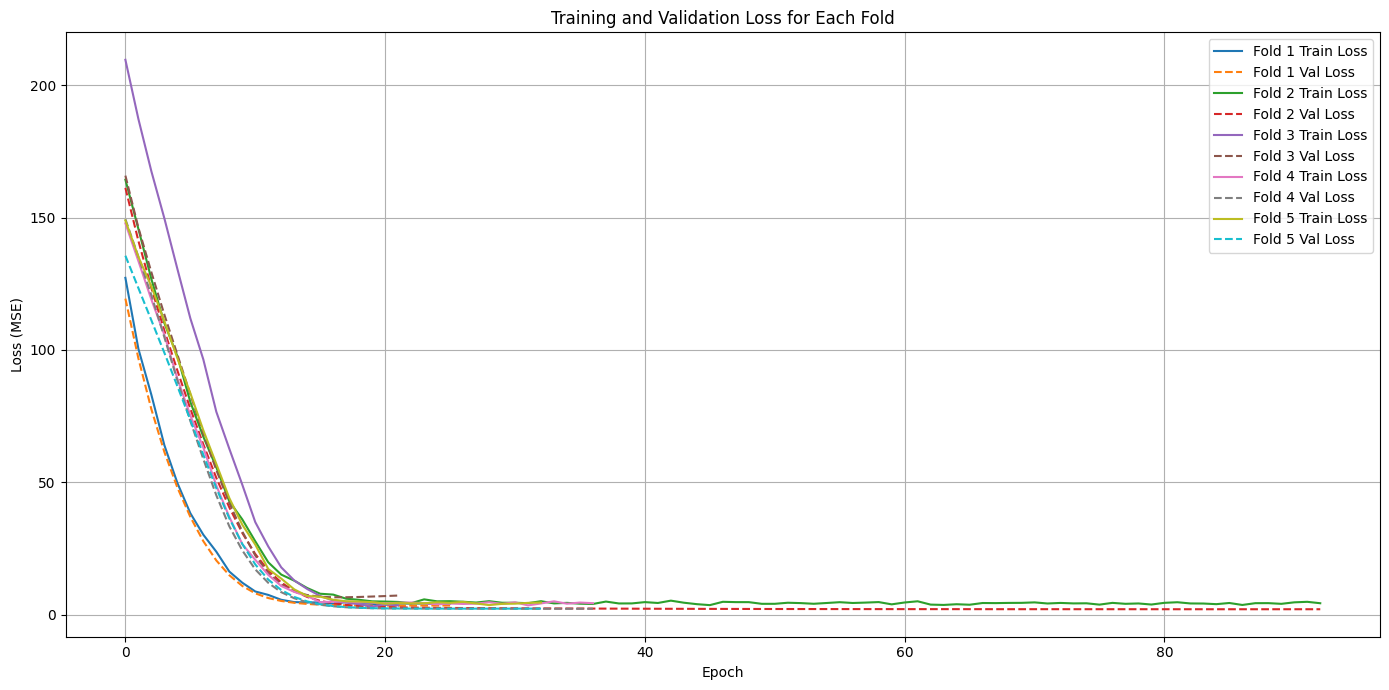

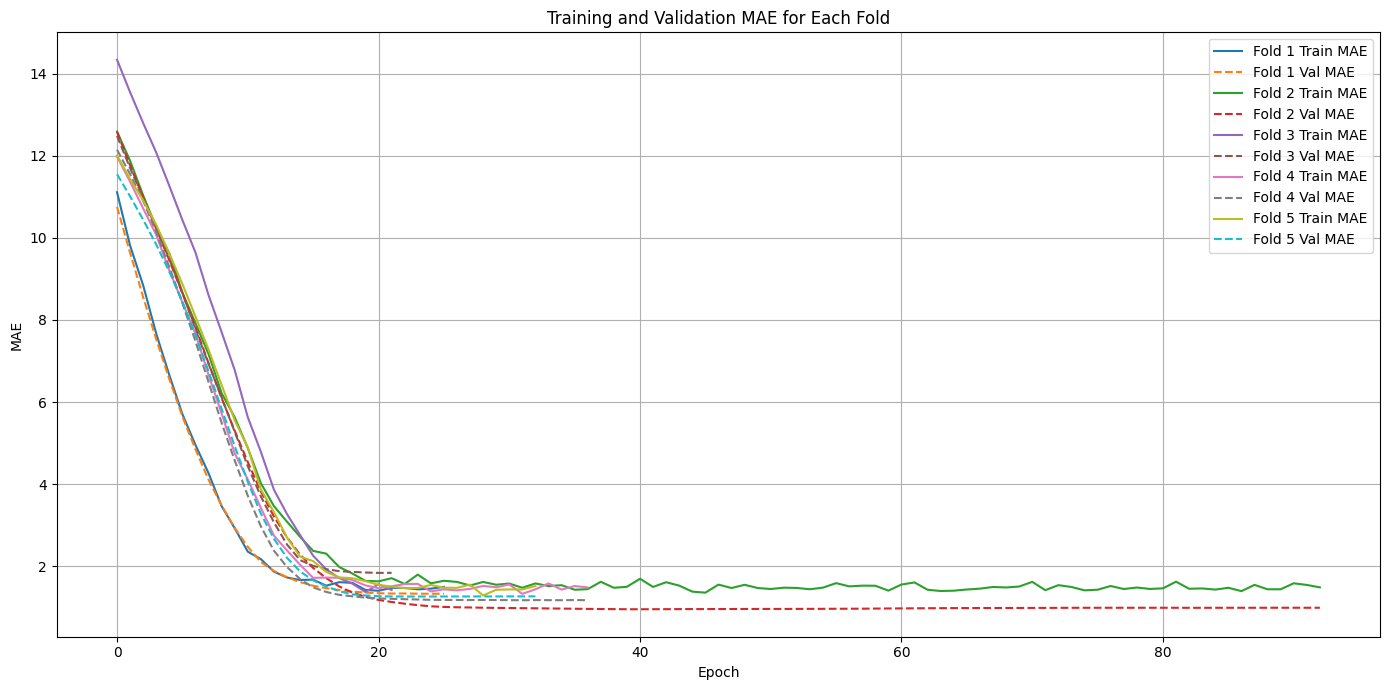


Durchschnittlicher CV MSE: 3.2923, Durchschnittlicher CV MAE: 1.3394
Testverlust auf realen Daten: 3.5105, Test-MAE auf realen Daten: 1.3071
Max MSE: 6.5541 (Fold 3)
Min MSE: 2.0342 (Fold 2)
Max MAE: 1.9284 (Fold 3)
Min MAE: 0.9889 (Fold 2)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
Anzahl der Zeilen in der CSV zum Aktualisieren: 157
Anzahl der Vorhersagen: 157
Vorhersagen wurden in die Datei C:\Users\Peter\Documents\Repos\slp\Image_Detect\meine_andere_datei_mit_pred.csv geschrieben.
         Record-ID TrainOrDev Class  Gender   Age  Converted-MMSE    BL  \
0  Process-rec-001      train   MCI    male  62.0            25.0  Null   
1  Process-rec-002        dev   MCI    male  61.0            25.0  Null   
2  Process-rec-003      train   MCI  female  62.0            29.0  Null   
3  Process-rec-004        dev   MCI  female  67.0            29.0  Null   
4  Process-rec-005      train   MCI    male  65.0            27.0  Null   

          PS    KW         ps  
0  26.600159  Null  27.088438 

C:\Users\Peter\AppData\Local\Temp\ipykernel_26592\4281378811.py:253: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1, 0], data=df, x='Gender', y='Converted-MMSE', palette='pastel')
C:\Users\Peter\AppData\Local\Temp\ipykernel_26592\4281378811.py:257: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1, 1], data=df, x='Gender', y='PS', palette='pastel')


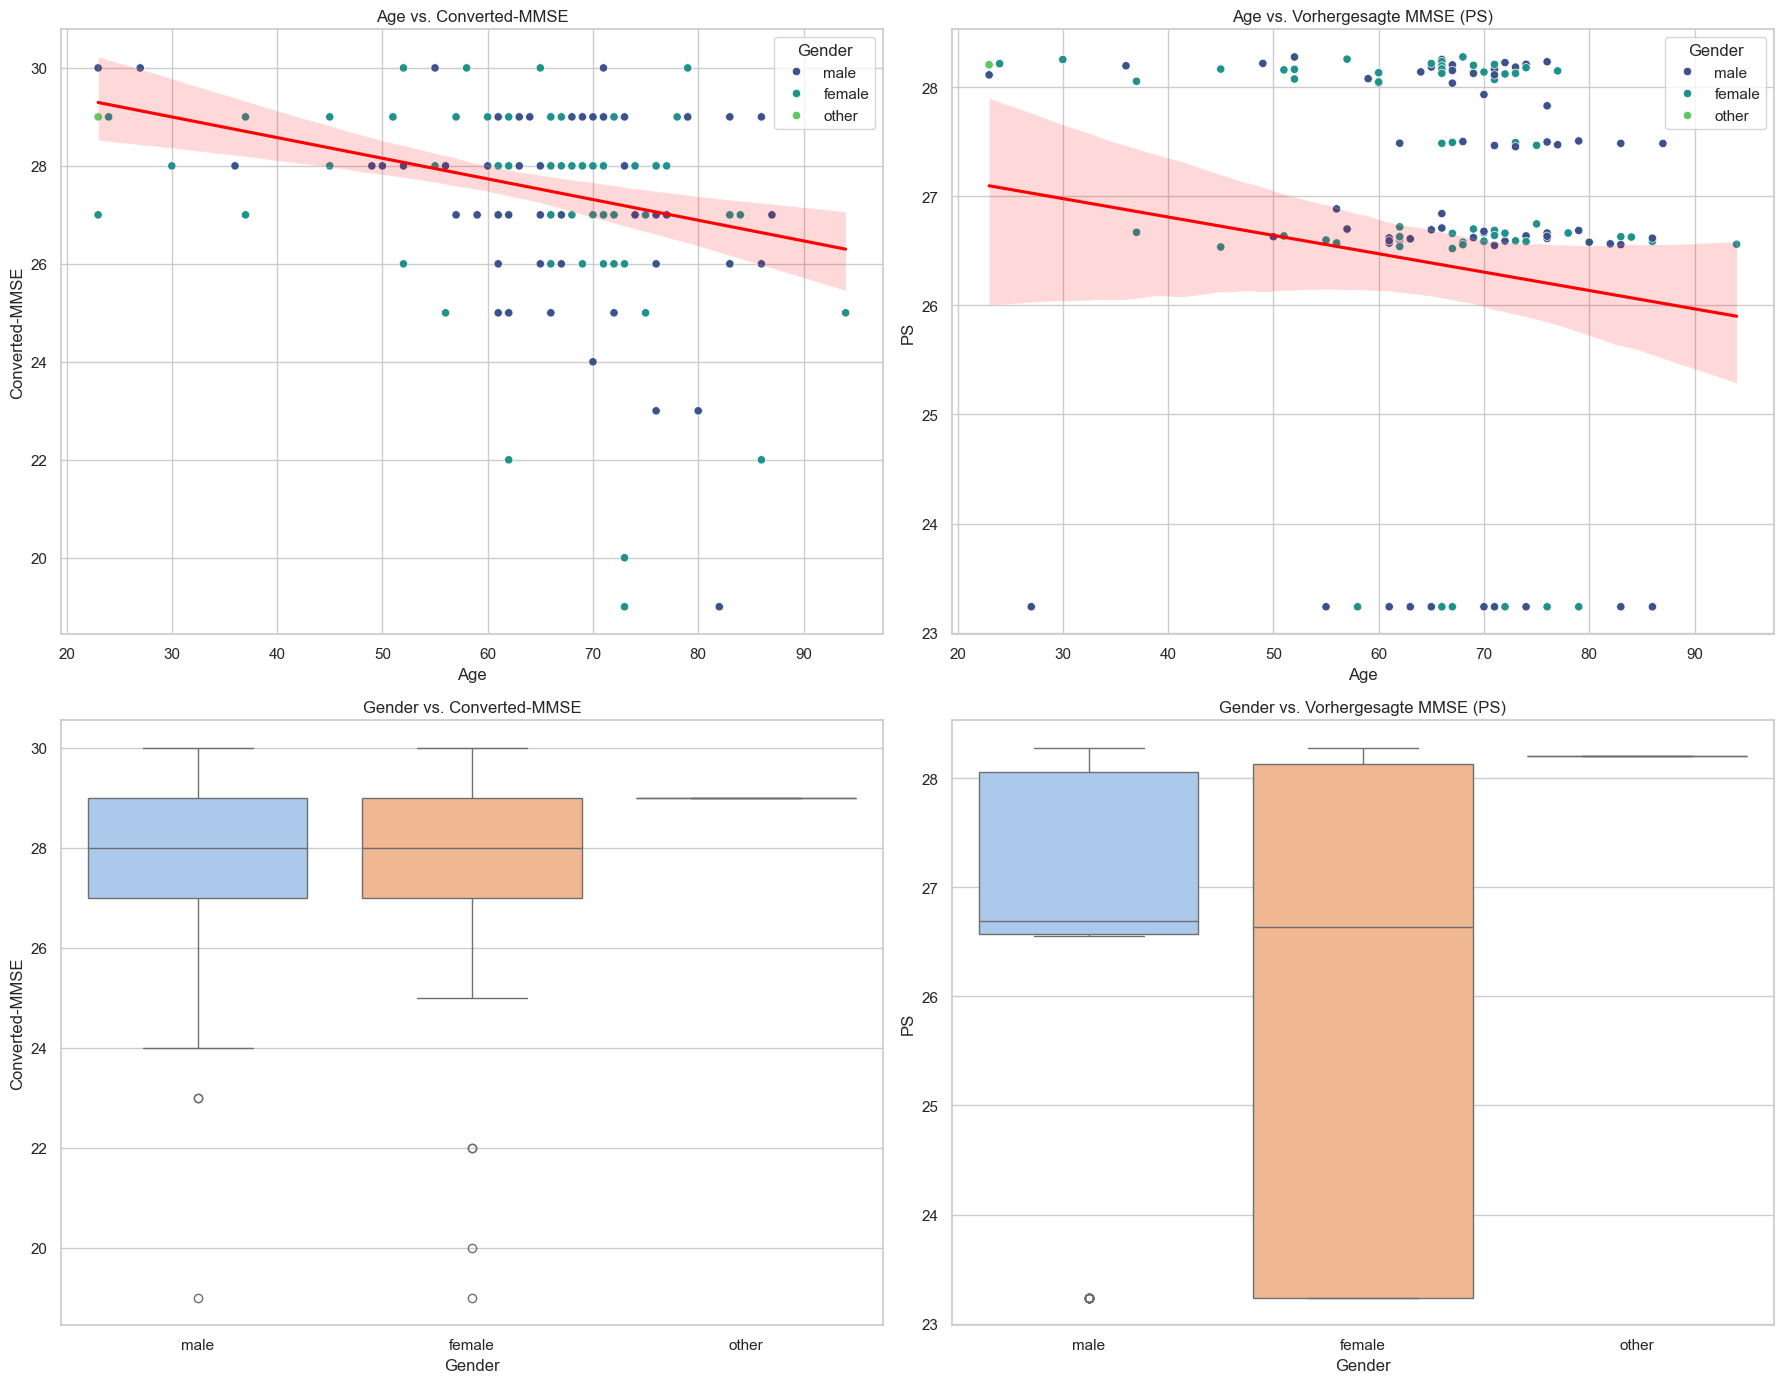

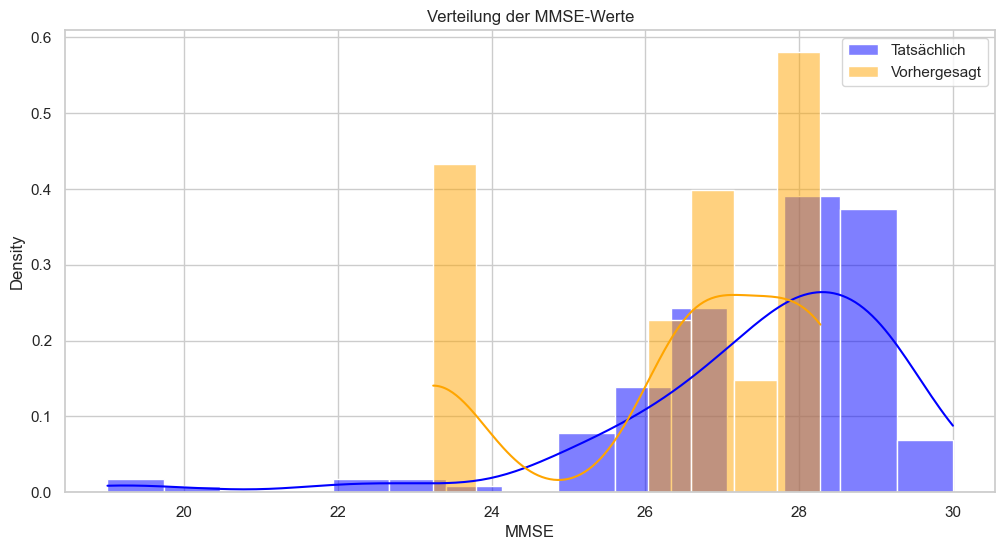

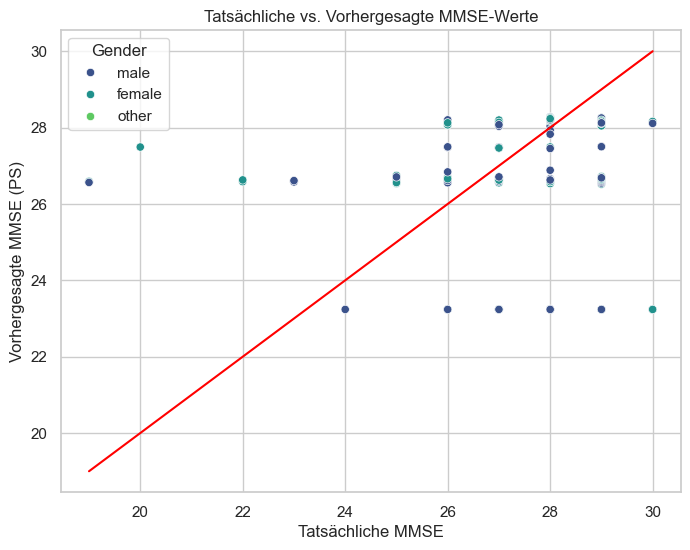

C:\Users\Peter\AppData\Local\Temp\ipykernel_26592\4281378811.py:290: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0], data=df, x='TrainOrDev', y='Converted-MMSE', palette='Set2')
C:\Users\Peter\AppData\Local\Temp\ipykernel_26592\4281378811.py:293: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], data=df, x='TrainOrDev', y='PS', palette='Set2')


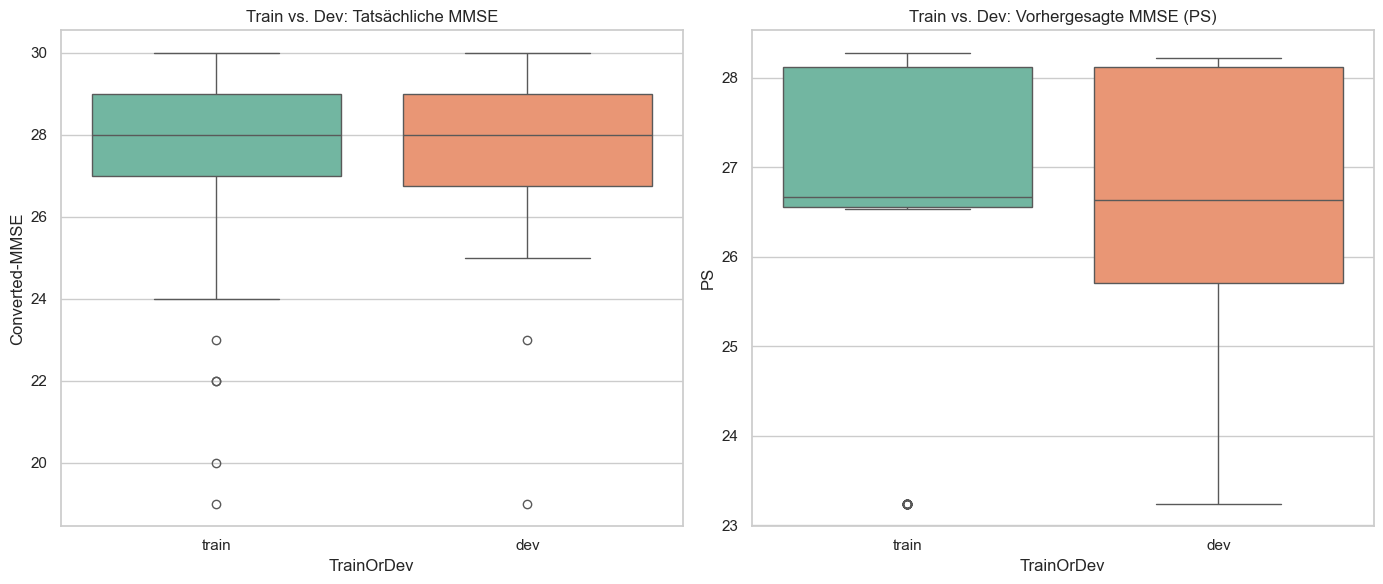

In [21]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Flatten, Dense, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# -------------------------------
# Schritt 1: Daten laden und vorbereiten
# -------------------------------


# Lade die Datensätze
confidence_scores = pd.read_csv(output_path)
mmse_scores = pd.read_csv(file_path)  # Enthält sowohl reale als auch synthetische Daten
print(f"Gesamtanzahl MMSE-Einträge (inkl. synthetisch): {len(mmse_scores)}")
real_mmse_scores = pd.read_csv(file_path_only_real_data)  # Nur reale Daten

# Behalte nur die relevanten Spalten für MMSE-Werte
mmse_scores = mmse_scores[['Record-ID', 'Converted-MMSE']]
real_mmse_scores = real_mmse_scores[['Record-ID', 'Converted-MMSE']]

# Merge-Daten auf 'Record-ID'
merged_data = pd.merge(confidence_scores, mmse_scores, on='Record-ID')

# Merge mit Outer Join, um fehlende Werte zu behalten
merged_data_outer = pd.merge(confidence_scores, mmse_scores, on='Record-ID', how='outer')

# Fehlende Werte mit 0 auffüllen
merged_data_outer.fillna(0, inplace=True)

print(f"Gesamtanzahl gemischter Daten (inkl. synthetisch): {len(merged_data)}")
real_data = pd.merge(confidence_scores, real_mmse_scores, on='Record-ID')

# Features und Ziel für alle Daten
features = merged_data[['Class-0', 'Class-1', 'Class-2']]
features_outer = merged_data_outer[['Class-0', 'Class-1', 'Class-2']]

print(f"Gesamtanzahl Features: {len(features)}")
target = merged_data['Converted-MMSE']

# Features und Ziel für reale Daten
real_features = real_data[['Class-0', 'Class-1', 'Class-2']]
real_target = real_data['Converted-MMSE']

# Option zur Auswahl, ob nur reale Daten zum Training verwendet werden sollen
use_real_data_only_for_training = False  # Setze auf False, um synthetische Daten einzubeziehen

if use_real_data_only_for_training:
    X_train_data, y_train_data = real_features, real_target
    print("Es werden nur reale Daten zum Training verwendet.")
else:
    X_train_data, y_train_data = features, target
    print("Es werden alle Daten (inkl. synthetisch) zum Training verwendet.")

# -------------------------------
# Schritt 2: Modelltraining mit K-Fold Cross-Validation
# -------------------------------

# Initialisiere KFold mit 5 Splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Listen zur Speicherung der Ergebnisse
fold_mse = []
fold_mae = []

# Listen zur Speicherung der Trainingshistorien
train_histories = []

# Starte die Kreuzvalidierung
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_data)):
    print(f"\nTraining Fold {fold + 1}...")
    
    # Split in Trainings- und Validierungsdaten
    X_train, X_val = X_train_data.iloc[train_idx], X_train_data.iloc[val_idx]
    y_train, y_val = y_train_data.iloc[train_idx], y_train_data.iloc[val_idx]

    # Normalisiere die Features
    scaler = MinMaxScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_val_normalized = scaler.transform(X_val)
    
    # Reshape für CNN
    X_train_cnn = np.expand_dims(X_train_normalized, axis=-1)
    X_val_cnn = np.expand_dims(X_val_normalized, axis=-1)
    
    # Definiere das CNN-Modell
    cnn_model = Sequential([
        Conv1D(filters=16, kernel_size=2, activation='relu', input_shape=(3, 1)),
        Dropout(0.2),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid'),
        Lambda(lambda x: x * 30)  # Skaliert die Ausgabe auf [0, 30]
    ])
    
    # Kompiliere das Modell
    cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    
    # Early Stopping zur Vermeidung von Overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Trainiere das Modell
    history = cnn_model.fit(
        X_train_cnn, y_train,
        validation_data=(X_val_cnn, y_val),
        epochs=100,
        batch_size=16,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Speichere die Trainingshistorie
    train_histories.append(history)
    
    # Evaluierung auf den Validierungsdaten
    val_predictions = cnn_model.predict(X_val_cnn).flatten()
    mse = mean_squared_error(y_val, val_predictions)
    mae = mean_absolute_error(y_val, val_predictions)
    
    print(f"Fold {fold + 1} - MSE: {mse:.4f}, MAE: {mae:.4f}")
    
    fold_mse.append(mse)
    fold_mae.append(mae)

# -------------------------------
# Schritt 3: Plotten der Trainingshistorien
# -------------------------------

# Plot der Trainings- und Validierungsverluste für alle Folds
plt.figure(figsize=(14, 7))
for i, history in enumerate(train_histories):
    plt.plot(history.history['loss'], label=f'Fold {i+1} Train Loss')
    plt.plot(history.history['val_loss'], linestyle='--', label=f'Fold {i+1} Val Loss')
plt.title('Training and Validation Loss for Each Fold')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Plot der Trainings- und Validierungs-MAE für alle Folds
plt.figure(figsize=(14, 7))
for i, history in enumerate(train_histories):
    plt.plot(history.history['mae'], label=f'Fold {i+1} Train MAE')
    plt.plot(history.history['val_mae'], linestyle='--', label=f'Fold {i+1} Val MAE')
plt.title('Training and Validation MAE for Each Fold')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# Schritt 4: Test auf realen Daten und Speichern der Vorhersagen
# -------------------------------

# Verwende den letzten Skalierer (kann angepasst werden, um einen konsistenten Skalierer zu verwenden)
normalized = scaler.transform(features_outer)
cnn = np.expand_dims(normalized, axis=-1)

real_normalized = scaler.transform(real_features)
real_cnn = np.expand_dims(real_normalized, axis=-1)
test_loss, test_mae = cnn_model.evaluate(real_cnn, real_target, verbose=0)

# Anzeige der Metriken
print(f"\nDurchschnittlicher CV MSE: {np.mean(fold_mse):.4f}, Durchschnittlicher CV MAE: {np.mean(fold_mae):.4f}")
print(f"Testverlust auf realen Daten: {test_loss:.4f}, Test-MAE auf realen Daten: {test_mae:.4f}")

# Berechnung von Max/Min für MSE und MAE
max_mse = max(fold_mse)
min_mse = min(fold_mse)
max_mae = max(fold_mae)
min_mae = min(fold_mae)

max_mse_fold = fold_mse.index(max_mse) + 1  # Fold-Index ist 0-basiert
min_mse_fold = fold_mse.index(min_mse) + 1
max_mae_fold = fold_mae.index(max_mae) + 1
min_mae_fold = fold_mae.index(min_mae) + 1

# Anzeige der Ergebnisse
print(f"Max MSE: {max_mse:.4f} (Fold {max_mse_fold})")
print(f"Min MSE: {min_mse:.4f} (Fold {min_mse_fold})")
print(f"Max MAE: {max_mae:.4f} (Fold {max_mae_fold})")
print(f"Min MAE: {min_mae:.4f} (Fold {min_mae_fold})")

# Generiere Vorhersagen für die realen Daten
real_predictions = cnn_model.predict(cnn).flatten()

# Pfad zur aktualisierten CSV-Datei
csv_to_update_path = r'C:\Users\Peter\Documents\Repos\slp\results-BL-PS-KW.csv'  # Ersetze durch den tatsächlichen Pfad
df_to_update = pd.read_csv(csv_to_update_path)

print(f"Anzahl der Zeilen in der CSV zum Aktualisieren: {len(df_to_update)}")
print(f"Anzahl der Vorhersagen: {len(real_predictions)}")

# Optional: Überprüfe, ob die Anzahl der Zeilen übereinstimmt
if len(df_to_update) != len(real_predictions):
    raise ValueError("Die Anzahl der Zeilen in der CSV stimmt nicht mit der Anzahl der Vorhersagen überein.")

# Füge eine neue Spalte mit den Vorhersagen hinzu
df_to_update["PS"] = real_predictions

# Speichere die aktualisierte CSV an einem neuen Ort
new_csv_path = os.path.join(os.getcwd(), "meine_andere_datei_mit_pred.csv")
df_to_update.to_csv(new_csv_path, index=False)

print(f"Vorhersagen wurden in die Datei {new_csv_path} geschrieben.")

# -------------------------------
# Schritt 5: Visualisierungen erstellen
# -------------------------------

# Lade die aktualisierte CSV mit den Vorhersagen
df = pd.read_csv(new_csv_path)

# Überprüfe die ersten Zeilen
print(df.head())

# Überblick über die Daten
print(df.info())

# Statistische Zusammenfassung
print(df.describe())

# Setze den Stil für Seaborn
sns.set(style="whitegrid")

# Erstelle eine 2x2 Grid für die Plots
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Age vs. Converted-MMSE
sns.scatterplot(ax=axes[0, 0], data=df, x='Age', y='Converted-MMSE', hue='Gender', palette='viridis')
sns.regplot(ax=axes[0, 0], data=df, x='Age', y='Converted-MMSE', scatter=False, color='red')
axes[0, 0].set_title('Age vs. Converted-MMSE')
axes[0, 0].legend(title='Gender')

# 2. Age vs. PS (Vorhergesagte MMSE)
sns.scatterplot(ax=axes[0, 1], data=df, x='Age', y='PS', hue='Gender', palette='viridis')
sns.regplot(ax=axes[0, 1], data=df, x='Age', y='PS', scatter=False, color='red')
axes[0, 1].set_title('Age vs. Vorhergesagte MMSE (PS)')
axes[0, 1].legend(title='Gender')

# 3. Gender vs. Converted-MMSE
sns.boxplot(ax=axes[1, 0], data=df, x='Gender', y='Converted-MMSE', palette='pastel')
axes[1, 0].set_title('Gender vs. Converted-MMSE')

# 4. Gender vs. PS (Vorhergesagte MMSE)
sns.boxplot(ax=axes[1, 1], data=df, x='Gender', y='PS', palette='pastel')
axes[1, 1].set_title('Gender vs. Vorhergesagte MMSE (PS)')

# Layout anpassen und anzeigen
plt.tight_layout()
plt.show()

# -------------------------------
# Optional: Erweiterte Visualisierungen
# -------------------------------

# 1. Histogramme der MMSE-Werte
plt.figure(figsize=(12, 6))
sns.histplot(df['Converted-MMSE'], kde=True, color='blue', label='Tatsächlich', stat="density")
sns.histplot(df['PS'], kde=True, color='orange', label='Vorhergesagt', stat="density")
plt.title('Verteilung der MMSE-Werte')
plt.xlabel('MMSE')
plt.legend()
plt.show()

# 2. Korrelation zwischen tatsächlichen und vorhergesagten MMSE-Werten
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Converted-MMSE', y='PS', hue='Gender', palette='viridis')
sns.lineplot(data=df, x='Converted-MMSE', y='Converted-MMSE', color='red')  # 45-Grad-Linie
plt.title('Tatsächliche vs. Vorhergesagte MMSE-Werte')
plt.xlabel('Tatsächliche MMSE')
plt.ylabel('Vorhergesagte MMSE (PS)')
plt.legend(title='Gender')
plt.show()

# 3. Box-Plots für weitere Kategorien (z.B. TrainOrDev)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(ax=axes[0], data=df, x='TrainOrDev', y='Converted-MMSE', palette='Set2')
axes[0].set_title('Train vs. Dev: Tatsächliche MMSE')

sns.boxplot(ax=axes[1], data=df, x='TrainOrDev', y='PS', palette='Set2')
axes[1].set_title('Train vs. Dev: Vorhergesagte MMSE (PS)')

plt.tight_layout()
plt.show()


In [24]:
import pandas as pd

# Step 1: Load the CSV file
df = pd.read_csv("meine_andere_datei_mit_pred.csv")

# Step 2: Display the original DataFrame (optional)
print("Original DataFrame:")
print(df)

# Step 3: Remove the column (replace 'column_name' with the actual column name)
df = df.drop(columns=['ps'])

# Step 4: Display the modified DataFrame (optional)
print("Modified DataFrame:")
print(df)

# Step 5: Save the modified DataFrame back to a CSV file (optional)
df.to_csv('modified_file.csv', index=False)

Original DataFrame:
           Record-ID TrainOrDev     Class  Gender   Age  Converted-MMSE    BL  \
0    Process-rec-001      train       MCI    male  62.0            25.0  Null   
1    Process-rec-002        dev       MCI    male  61.0            25.0  Null   
2    Process-rec-003      train       MCI  female  62.0            29.0  Null   
3    Process-rec-004        dev       MCI  female  67.0            29.0  Null   
4    Process-rec-005      train       MCI    male  65.0            27.0  Null   
..               ...        ...       ...     ...   ...             ...   ...   
152  Process-rec-153      train        HC    male  63.0            28.0  Null   
153  Process-rec-154      train        HC  female  79.0            30.0  Null   
154  Process-rec-155      train        HC    male  86.0            29.0  Null   
155  Process-rec-156      train  Dementia    male  61.0            26.0  Null   
156  Process-rec-157      train        HC    male  65.0            28.0  Null   

       

In [ ]:
(use_real_data_only_for_training = False)

Average CV MSE: 3.4729099120120694, Average CV MAE: 1.3490615354068036
Test Loss on Real + Synthetic Data: 4.200306415557861, Test MAE on Real + Synthetic Data: 1.450698733329773
Max MSE: 7.342378159593712 (Fold 3)
Min MSE: 2.046630994379939 (Fold 4)
Max MAE: 1.9241284529368083 (Fold 3)
Min MAE: 1.1551274458567302 (Fold 4)

In [ ]:
Average CV MSE: 3.6506111587234864, Average CV MAE: 1.3543349970941958
Test Loss on Real Data: 4.19854211807251, Test MAE on Real Data: 1.4790438413619995
Max MSE: 8.244373843523439 (Fold 3)
Min MSE: 2.18855827628416 (Fold 2)
Max MAE: 2.035761992136637 (Fold 3)
Min MAE: 1.0409241517384846 (Fold 2)

In [40]:
from lime.lime_tabular import LimeTabularExplainer

# Initialize the LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train_normalized,
    training_labels=y_train.values,
    feature_names=['Class-0', 'Class-1', 'Class-2'],
    mode='regression'
)

# Explain a single test instance
test_instance = X_test_normalized[0]
exp = explainer.explain_instance(
    test_instance, cnn_model.predict, num_features=3
)

# Display the explanation
exp.show_in_notebook()


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
